In [1]:
!pip install Catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [2]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/

In [3]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
print("What is the period for which you are looking to invest\n")
print("1) 3 Months")
print("2) 1 Month")
print("3) 2 weeks")
print('4) 1 week')
start_date = "2000-01-01"
end_date = "2024-10-10"
end_date_test = "2024-10-17"



n = int(input("Enter a digit corresponding to your choice of Time Period: "))

if n==1:
    period = '3m'
elif n==2:
    period = '1m'
elif n==3:
    period = '2w'
elif n==4:
    period = '1w'
else:
    "Enter a valid input"


# if(period == '1y'):
#     tr_pct = 12.3
#     rr = 0.34
#     no_of_days = 252
#     rfr = 0.07
# elif(period =='6m'):
#     tr_pct = 6.1986
#     rr = 0.34
#     no_of_days = 126
#     rfr = 0.034408043278860045
if(period == '3m'):
    tr_pct = 3.0899
    rr = 0.34
    no_of_days = 63
    rfr = 0.017058525001811375
elif(period == '1m'):
    tr_pct = 1.0168
    rr = 0.34
    no_of_days = 21
    rfr = 0.005654145387405274
elif(period == '2w'):
    tr_pct = 0.488
    rr = 0.34
    no_of_days = 10
    rfr = 0.0022
elif(period == '1w'):
    tr_pct = 0.243
    rr = 0.34
    no_of_days = 5
    rfr = 0.0011

What is the period for which you are looking to invest

1) 3 Months
2) 1 Month
3) 2 weeks
4) 1 week
Enter a digit corresponding to your choice of Time Period: 4


In [6]:
def get_signal(ticker,tr_pct,rr,no_of_days):

    # Use the yfinance library to get the historical data
    df = yf.download(ticker, start=start_date, end=end_date)
    df = df[['High','Low','Adj Close','Volume']]
    df.dropna(how='any', inplace=True)
    adj=df['Adj Close'].to_numpy().flatten().astype(np.float64)
    low=df['Low'].to_numpy().flatten().astype(np.float64)
    high=df['High'].to_numpy().flatten().astype(np.float64)
    vol=df['Volume'].to_numpy().flatten().astype(np.float64)

    # Calculate Simple Moving Average (SMA)
    df['SMA-21'] = talib.SMA(adj, timeperiod=21)
    df['SMA-55'] = talib.SMA(adj, timeperiod=55)
    df['SMA-100'] = talib.SMA(adj, timeperiod=100)
    df['SMA-200'] = talib.SMA(adj, timeperiod=200)

    #Calculate Chaikin A/D Oscillator
    df['ADOSC'] = talib.ADOSC(high, low, adj, vol, fastperiod=3, slowperiod=10)

    # Calculate Exponential Moving Average (EMA)
    df['EMA-12'] = talib.EMA(adj, timeperiod=12)
    df['EMA-26'] = talib.EMA(adj, timeperiod=26)
    df['EMA-50'] = talib.EMA(adj, timeperiod=50)
    df['EMA-200'] = talib.EMA(adj, timeperiod=200)

    # Calculate Relative Strength Index (RSI)
    df['RSI-5'] = talib.RSI(adj, timeperiod=5)
    df['RSI-14'] = talib.RSI(adj, timeperiod=14)

    # Calculate Moving Average Convergence Divergence (MACD)
    macd, signal, _ = talib.MACD(adj, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = _

    # Calculate Bollinger Bands
    upper, middle, lower = talib.BBANDS(adj, timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BB_upper'] = upper
    df['BB_middle'] = middle
    df['BB_lower'] = lower

    df['BB_upper'] = (df['BB_upper'] - adj) / adj * 100
    df['BB_middle'] = (df['BB_middle'] - adj) / adj * 100
    df['BB_lower'] = (df['BB_lower'] - adj) / adj * 100

    df['ADX'] = talib.ADX(high, low, adj, timeperiod=14)
    df['ATR'] = talib.ATR(high, low, adj, timeperiod=14)

    #Calculate Chaikin A/D Oscillator
    df['ADOSC'] = talib.ADOSC(high, low, adj, vol, fastperiod=3, slowperiod=10)

    # Calculate Hilbert Transform - Dominant Cycle Period (HT_DCPERIOD)
    df['dc_period'] = talib.HT_DCPERIOD(adj)

    # Calculate Hilbert Transform - Dominant Cycle Phase (HT_DCPHASE)
    df['dc_phase'] = talib.HT_DCPHASE(adj)

    df['pct_change'] = df['Adj Close'].pct_change(periods=no_of_days) * 100
    df['pct_change'] = df['pct_change'].shift(-no_of_days)

    columns_to_replace = ['SMA-21', 'SMA-55', 'SMA-100', 'SMA-200', 'EMA-12', 'EMA-26', 'EMA-50', 'EMA-200']

    # Iterate over the columns and replace the values based on 'Adj Close'
    for column in columns_to_replace:
        df[column] = ((adj - df[column]) / adj) * 100

    last_row = df.tail(1)

    df.dropna(how='any', inplace=True)

    # Create a new column based on the conditions
    df['Signal'] = 0
    df.loc[(df['pct_change'] >= tr_pct), 'Signal'] = 1
    df = df.drop(columns={'pct_change'})

    features = ['SMA-21', 'SMA-55', 'SMA-100', 'SMA-200', 'EMA-12', 'EMA-26', 'EMA-50',
                'EMA-200', 'RSI-5', 'RSI-14', 'MACD', 'BB_upper', 'BB_middle', 'BB_lower',
                'ADX','ATR','ADOSC','dc_period','dc_phase']

    target = 'Signal'

    X = df[features].values
    y = df[target].values

    # Preprocess the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # Split the preprocessed data into training and testing sets
    # Splitting the data with the last 100 samples as the test set

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Define the base classifiers
    rf = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=500)
    gb = GradientBoostingClassifier(learning_rate=0.1)
    bc = BaggingClassifier(max_features=1.0, max_samples=1.0, n_estimators=100)
    knn = KNeighborsClassifier(algorithm='auto', n_neighbors=5, weights='distance')

    lgb_params = {
        'objective': 'binary',  # Binary classification objective
        'verbose': 0
    }
    lgb_model = LGBMClassifier(**lgb_params,force_col_wise=True)

    # CatBoost binary classifier
    catboost_params = {
        'loss_function': 'Logloss',
        'verbose': 0            # Set verbose to 0 to avoid printing progress
    }
    catboost_model = CatBoostClassifier(**catboost_params)

    # Soft voting classifier
    voting_soft = VotingClassifier(
        estimators=[('rf', rf), ('gb', gb),('bc',bc),('knn', knn), ('lgb_model', lgb_model), ('catboost_model', catboost_model)],
        voting='soft'
    )



    # Fit the soft voting classifier on the oversampled training data
    voting_soft.fit(X_train, y_train)

    y_pred_soft = voting_soft.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_soft))
    print("Accuracy:", accuracy_score(y_test, y_pred_soft) * 100)
    print("Precision:", precision_score(y_test, y_pred_soft) * 100)

    # Extract features from the last row
    features_last_row = last_row[features]

    # Preprocess the features of the last row
    features_last_row = scaler.transform(features_last_row)

    # Make the prediction
    predicted_signal = voting_soft.predict(features_last_row)


    # Assign the predicted value to the 'Signal' column of the last row
    last_row.loc[:, 'Signal'] = predicted_signal

    if last_row.loc[:, 'Signal'].values[0] == 1:
        return run_classification(ticker,rr,no_of_days)

    # Return the predicted signal
    else:
        return last_row.loc[:, 'Signal'].values[0]

In [7]:
# import warnings
# # Ignore all warnings
# warnings.filterwarnings("ignore")

def run_classification(ticker,rr,no_of_days):

    # Download historical data for the ticker
    df = yf.download(ticker, start=start_date, end=end_date)
    df.dropna(how='any', inplace=True)
    df = df[['Open','High','Low','Adj Close','Volume']]
    adj=df['Adj Close'].to_numpy().flatten().astype(np.float64)
    low=df['Low'].to_numpy().flatten().astype(np.float64)
    high=df['High'].to_numpy().flatten().astype(np.float64)
    vol=df['Volume'].to_numpy().flatten().astype(np.float64)


    # Calculate Simple Moving Average (SMA)
    df['SMA-21'] = talib.SMA(adj, timeperiod=21)
    df['SMA-55'] = talib.SMA(adj, timeperiod=55)
    df['SMA-100'] = talib.SMA(adj, timeperiod=100)
    df['SMA-200'] = talib.SMA(adj, timeperiod=200)

    # Calculate Exponential Moving Average (EMA)
    df['EMA-12'] = talib.EMA(adj, timeperiod=12)
    df['EMA-26'] = talib.EMA(adj, timeperiod=26)
    df['EMA-50'] = talib.EMA(adj, timeperiod=50)
    df['EMA-200'] = talib.EMA(adj, timeperiod=200)

    # Calculate Relative Strength Index (RSI)
    df['RSI-5'] = talib.RSI(adj, timeperiod=5)
    df['RSI-14'] = talib.RSI(adj, timeperiod=14)

    # Calculate Moving Average Convergence Divergence (MACD)
    macd, signal, _ = talib.MACD(adj, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = _

    # Calculate Bollinger Bands
    upper, middle, lower = talib.BBANDS(adj, timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BB_upper'] = upper
    df['BB_middle'] = middle
    df['BB_lower'] = lower

    df['BB_upper'] = (df['BB_upper'] - adj) / adj * 100
    df['BB_middle'] = (df['BB_middle'] - adj) / adj * 100
    df['BB_lower'] = (df['BB_lower'] - adj) / adj * 100

    df['ADX'] = talib.ADX(high, low, adj, timeperiod=14)
    df['ATR'] = talib.ATR(high, low, adj, timeperiod=14)

    df['ADOSC'] = talib.ADOSC(high, low, adj, vol, fastperiod=3, slowperiod=10)
    # Calculate Hilbert Transform - Dominant Cycle Period (HT_DCPERIOD)
    df['dc_period'] = talib.HT_DCPERIOD(adj)

    # Calculate Hilbert Transform - Dominant Cycle Phase (HT_DCPHASE)
    df['dc_phase'] = talib.HT_DCPHASE(adj)

    df['High'] = df['High'].rolling(no_of_days).max().shift(-no_of_days)
    df['Low'] = df['Low'].rolling(no_of_days).min().shift(-no_of_days)
    df['High'] = (df['High'] - df['Open'])/df['Open']
    df['Low'] = np.abs((df['Low'] - df['Open'])/df['Open'])
    df['Ratio'] = df['Low'] / df['High']

    df['Signal'] = 0
    df.loc[df['Ratio'] < rr, 'Signal'] = 1
    df.loc[df['Ratio'] >= rr, 'Signal'] = 0

    columns_to_replace = ['SMA-21', 'SMA-55', 'SMA-100', 'SMA-200', 'EMA-12', 'EMA-26', 'EMA-50', 'EMA-200']
    for column in columns_to_replace:
        df[column] = ((adj - df[column]) / adj) * 100

    last_row = df.tail(1)
    df.dropna(how='any', inplace=True)

    features = ['SMA-21', 'SMA-55', 'SMA-100', 'SMA-200', 'EMA-12', 'EMA-26', 'EMA-50',
                'EMA-200', 'RSI-5', 'RSI-14', 'MACD', 'BB_upper', 'BB_middle', 'BB_lower',
                'ADX','ATR','ADOSC','dc_period','dc_phase']

    target = 'Signal'
    X = df[features]
    y = df[target].values

    # Preprocess the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # Split the preprocessed data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Define the optimized classifiers
    classifiers = [
        ('Bagging Classifier', BaggingClassifier(n_estimators=30, max_samples=1.0, max_features=1.0)),
        ('Gradient Boosting', GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=7)),
        ('KNN', KNeighborsClassifier(n_neighbors=3, weights='distance')),
        ('Random Forest', RandomForestClassifier(n_estimators=300, max_depth=7, min_samples_split=2)),
        ('lgb_model', LGBMClassifier(objective='binary', metric='binary_logloss', verbose=0, force_col_wise=True)),
        ('catboost_model', CatBoostClassifier(loss_function='Logloss', verbose=0))
    ]

    # Train and evaluate the classifiers
    voting_clf_hard = VotingClassifier(estimators=classifiers, voting='hard')
    voting_clf_hard.fit(X_train, y_train)

    # Evaluate the soft voting classifier on the testing set
    y_pred_hard = voting_clf_hard.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_hard))
    print("Accuracy:", accuracy_score(y_test, y_pred_hard) * 100)
    print("Precision:", precision_score(y_test, y_pred_hard) * 100)



    # Extract features from the last row
    features_last_row = last_row[features]

    # Preprocess the features of the last row
    features_last_row = scaler.transform(features_last_row)

    # Make the prediction
    predicted_signal = voting_clf_hard.predict(features_last_row)


    # Assign the predicted value to the 'Signal' column of the last row
    last_row.loc[:, 'Signal'] = predicted_signal

    # Return the predicted signal
    return last_row['Signal'].values[0]

In [8]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

tickers = ["^NSEBANK", "^CNXIT", "^CNXENERGY", "^CNXFMCG", "^CNXAUTO",
           "^CNXMETAL", "^CNXREALTY", "^CNXMEDIA", "^CNXCONSUM",
           "^CNXINFRA", "^CNXPSUBANK", "^CNXPSE", "^CNXSERVICE"]

bullish_sectors = []

for i in tickers:
    try:
        signal = get_signal(i, tr_pct, rr, no_of_days)
        if signal == 1:
            bullish_sectors.append(i)
            print(f"{i} is bullish")
        else:
            print(f"{i} is expected to give below average return")
    except Exception as e:
        print(f"Error processing {i}: {e}")


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[269  83]
 [ 90 299]]
Accuracy: 76.6531713900135
Precision: 78.27225130890052


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[288 125]
 [196 132]]
Accuracy: 56.68016194331984
Precision: 51.36186770428015
^NSEBANK is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[252 114]
 [ 75 297]]
Accuracy: 74.39024390243902
Precision: 72.26277372262774


Confusion Matrix:
[[299  72]
 [238 129]]
Accuracy: 57.994579945799465
Precision: 64.17910447761194
^CNXIT is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[224  65]
 [ 76 266]]
Accuracy: 77.65451664025356
Precision: 80.36253776435045


Confusion Matrix:
[[258  69]
 [188 116]]
Accuracy: 59.27099841521395
Precision: 62.70270270270271
^CNXENERGY is expected to give below average return


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[221  63]
 [ 70 277]]
Accuracy: 78.92234548335975
Precision: 81.47058823529412
^CNXFMCG is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[198  68]
 [ 86 257]]
Accuracy: 74.71264367816092
Precision: 79.07692307692308


Confusion Matrix:
[[220  92]
 [177 120]]
Accuracy: 55.82922824302135
Precision: 56.60377358490566
^CNXAUTO is bullish


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[242  64]
 [ 73 230]]
Accuracy: 77.504105090312
Precision: 78.2312925170068
^CNXMETAL is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[231  82]
 [ 72 273]]
Accuracy: 76.59574468085107
Precision: 76.90140845070422


Confusion Matrix:
[[243  85]
 [170 160]]
Accuracy: 61.246200607902736
Precision: 65.3061224489796
^CNXREALTY is bullish


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[241  56]
 [ 76 232]]
Accuracy: 78.18181818181819
Precision: 80.55555555555556
^CNXMEDIA is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[195  93]
 [ 55 265]]
Accuracy: 75.6578947368421
Precision: 74.02234636871509


Confusion Matrix:
[[223  93]
 [177 115]]
Accuracy: 55.5921052631579
Precision: 55.28846153846154
^CNXCONSUM is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[261  70]
 [ 73 254]]
Accuracy: 78.26747720364742
Precision: 78.39506172839506


Confusion Matrix:
[[271  74]
 [198 115]]
Accuracy: 58.662613981762924
Precision: 60.84656084656085
^CNXINFRA is expected to give below average return


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[245  57]
 [ 81 248]]
Accuracy: 78.12995245641838
Precision: 81.31147540983606
^CNXPSUBANK is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[239  97]
 [ 53 242]]
Accuracy: 76.2282091917591
Precision: 71.38643067846607


Confusion Matrix:
[[242  65]
 [194 130]]
Accuracy: 58.9540412044374
Precision: 66.66666666666666
^CNXPSE is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[222  89]
 [ 57 263]]
Accuracy: 76.8621236133122
Precision: 74.7159090909091


Confusion Matrix:
[[271  84]
 [172 104]]
Accuracy: 59.42947702060222
Precision: 55.319148936170215
^CNXSERVICE is expected to give below average return


In [9]:
NSEBANK = [
    "AUBANK.NS", "AXISBANK.NS", "BANDHANBNK.NS", "BANKBARODA.NS", "FEDERALBNK.NS",
    "HDFCBANK.NS", "ICICIBANK.NS", "IDFCFIRSTB.NS", "INDUSINDBK.NS", "KOTAKBANK.NS",
    "PNB.NS", "SBIN.NS"
]

CNXIT = [
    "COFORGE.NS", "HCLTECH.NS", "INFY.NS", "LTTS.NS", "LTIM.NS",
    "MPHASIS.NS", "PERSISTENT.NS", "TCS.NS", "TECHM.NS", "WIPRO.NS"
]

CNXENERGY = [
    "ADANIGREEN.NS", "BPCL.NS", "GAIL.NS", "HINDPETRO.NS", "IOC.NS",
    "NTPC.NS", "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "TATAPOWER.NS"
]

CNXFMCG = [
    "BRITANNIA.NS", "COLPAL.NS", "DABUR.NS", "EMAMILTD.NS", "GODREJCP.NS",
    "HINDUNILVR.NS", "ITC.NS", "JUBLFOOD.NS", "MARICO.NS", "NESTLEIND.NS",
    "PGHH.NS", "TATACONSUM.NS", "UBL.NS", "MCDOWELL-N.NS"
]

CNXAUTO = [
    "AMARAJABAT.NS", "ASHOKLEY.NS", "BAJAJ-AUTO.NS", "BALKRISIND.NS",
    "BHARATFORG.NS", "BOSCHLTD.NS", "EICHERMOT.NS", "EXIDEIND.NS",
    "HEROMOTOCO.NS", "M&M.NS", "MARUTI.NS", "MRF.NS", "TATAMOTORS.NS",
    "TIINDIA.NS", "TVSMOTOR.NS"
]

CNXMETAL = [
    "ADANIENT.NS", "APLAPOLLO.NS", "COALINDIA.NS", "HINDZINC.NS",
    "HINDALCO.NS", "JINDALSTEL.NS", "JSWSTEEL.NS", "MOIL.NS",
    "NATIONALUM.NS", "NMDC.NS", "RATNAMANI.NS", "SAIL.NS", "TATASTEEL.NS",
    "VEDL.NS", "WELCORP.NS"
]

CNXREALTY = [
    "BRIGADE.NS", "DLF.NS", "GODREJPROP.NS", "IBREALEST.NS",
    "OBEROIRLTY.NS", "PHOENIXLTD.NS", "PRESTIGE.NS", "SOBHA.NS", "SUNTECK.NS"
]

CNXMEDIA = [
    "DBCORP.NS", "DISHTV.NS","JAGRAN.NS", "NETWORK18.NS",
    "SUNTV.NS", "TVTODAY.NS", "TV18BRDCST.NS", "ZEEL.NS"
]

CNXCONSUM = [
    "APOLLOHOSP.NS", "ASIANPAINT.NS", "AVANTIFEED.NS", "BAJAJ-AUTO.NS", "BERGEPAINT.NS",
    "BHARTIARTL.NS", "BRITANNIA.NS", "CGCL.NS", "COLPAL.NS", "DABUR.NS",
    "EICHERMOT.NS", "GODREJCP.NS", "HAVELLS.NS", "HEROMOTOCO.NS", "HINDUNILVR.NS",
    "NAUKRI.NS", "INDIGO.NS", "ITC.NS", "JUBLFOOD.NS", "M&M.NS",
    "MARICO.NS", "MARUTI.NS", "NESTLEIND.NS", "PAGEIND.NS", "TATACONSUM.NS",
    "TITAN.NS", "TRENT.NS", "MCDOWELL-N.NS", "VOLTAS.NS", "ZEEL.NS"
]

CNXINFRA = [
    "ACC.NS", "ADANIPORTS.NS", "AMBUJACEM.NS", "APOLLOHOSP.NS", "ASHOKLEY.NS",
    "BALKRISIND.NS", "BHARTIARTL.NS", "BPCL.NS", "CONCOR.NS", "DLF.NS",
    "EXIDEIND.NS", "GAIL.NS", "GRASIM.NS", "HINDPETRO.NS", "IGL.NS",
    "INDUSTOWER.NS", "INDIGO.NS", "IOC.NS", "LT.NS", "MRF.NS",
    "NTPC.NS", "ONGC.NS", "PETRONET.NS", "POWERGRID.NS", "RAMCOCEM.NS",
    "RELIANCE.NS", "SHREECEM.NS", "SIEMENS.NS", "TATAPOWER.NS", "ULTRACEMCO.NS"
]

CNXPSUBANK = [
    "BANKBARODA.NS", "BANKINDIA.NS", "MAHABANK.NS", "CANBK.NS", "CENTRALBK.NS",
    "INDIANB.NS", "IOB.NS", "J&KBANK.NS", "PNB.NS", "PSB.NS",
    "SBIN.NS", "UCOBANK.NS", "UNIONBANK.NS"
]

CNXPSE = [
    "BEL.NS", "BHEL.NS", "BPCL.NS", "COALINDIA.NS", "CONCOR.NS",
    "GAIL.NS", "HINDPETRO.NS", "HAL.NS", "IOC.NS", "IRCTC.NS",
    "NATIONALUM.NS", "NHPC.NS", "NMDC.NS", "NTPC.NS", "OIL.NS",
    "ONGC.NS", "PFC.NS", "POWERGRID.NS", "RECLTD.NS", "SAIL.NS"
]

CNXSERVICE = [
    "ADANIGREEN.NS", "ADANIPORTS.NS", "DMART.NS", "AXISBANK.NS", "BAJFINANCE.NS",
    "BAJAJFINSV.NS", "BANDHANBNK.NS", "BHARTIARTL.NS", "GAIL.NS", "HCLTECH.NS",
    "HDFCBANK.NS", "HDFCLIFE.NS", "ICICIBANK.NS", "ICICIGI.NS",
    "ICICIPRULI.NS", "INDUSINDBK.NS", "NAUKRI.NS", "INFY.NS",
    "KOTAKBANK.NS", "NTPC.NS", "PETRONET.NS", "POWERGRID.NS",
    "SBIN.NS", "SBILIFE.NS", "SHRIRAMFIN.NS", "TCS.NS",
    "TECHM.NS", "WIPRO.NS", "ZEEL.NS"
]

In [10]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


tickers = []

# Create a dictionary to map sectors to their respective lists
sector_lists = {
    '^NSEBANK': NSEBANK,
    '^CNXIT': CNXIT,
    '^CNXMETAL': CNXMETAL,
    '^CNXINFRA': CNXINFRA,
    '^CNXPSE': CNXPSE,
    '^CNXENERGY':CNXENERGY,
    '^CNXFMCG':CNXFMCG,
    '^CNXAUTO':CNXAUTO,
    '^CNXREALTY':CNXREALTY,
    '^CNXMEDIA':CNXMEDIA,
    '^CNXCONSUM':CNXCONSUM,
    '^CNXPSUBANK':CNXPSUBANK,
    '^CNXSERVICE':CNXSERVICE

}


# Loop through the bullish sectors and access the corresponding list
for sector in bullish_sectors:
    try:
        if sector in sector_lists:
            stock_list = sector_lists[sector]
            for i in stock_list:
                if get_signal(i,tr_pct,rr,no_of_days) == 1:
                    tickers.append(i)
                    print(f"{i} is bullish")

                else:
                    print(f"{i} is expected to give below average return")

        else:
            print(f"No list found for sector {sector}")

    except:
        pass


tickers = list(set(tickers))

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AMARAJABAT.NS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[312  73]
 [ 89 312]]
Accuracy: 79.38931297709924
Precision: 81.03896103896105


Confusion Matrix:
[[338  70]
 [213 165]]
Accuracy: 63.99491094147582
Precision: 70.2127659574468
BRIGADE.NS is bullish


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[312  97]
 [ 87 315]]
Accuracy: 77.31196054254006
Precision: 76.45631067961165


Confusion Matrix:
[[362  76]
 [248 125]]
Accuracy: 60.04932182490752
Precision: 62.189054726368155
DLF.NS is bullish


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[271  83]
 [ 77 257]]
Accuracy: 76.74418604651163
Precision: 75.58823529411765


Confusion Matrix:
[[314  66]
 [211  97]]
Accuracy: 59.73837209302325
Precision: 59.50920245398773
GODREJPROP.NS is expected to give below average return


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[405  93]
 [121 330]]
Accuracy: 77.44994731296102
Precision: 78.01418439716312
IBREALEST.NS is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[272  64]
 [ 71 241]]
Accuracy: 79.16666666666666
Precision: 79.01639344262294


Confusion Matrix:
[[302  61]
 [202  83]]
Accuracy: 59.413580246913575
Precision: 57.638888888888886
OBEROIRLTY.NS is bullish


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[324 109]
 [110 278]]
Accuracy: 73.32521315468941
Precision: 71.83462532299741


Confusion Matrix:
[[394  79]
 [235 113]]
Accuracy: 61.75395858708892
Precision: 58.854166666666664
PHOENIXLTD.NS is expected to give below average return


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[256  69]
 [ 75 247]]
Accuracy: 77.74343122102009
Precision: 78.16455696202532


Confusion Matrix:
[[304  68]
 [166 109]]
Accuracy: 63.83307573415765
Precision: 61.5819209039548
PRESTIGE.NS is bullish


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Confusion Matrix:
[[359  78]
 [123 277]]
Accuracy: 75.98566308243727
Precision: 78.0281690140845


Confusion Matrix:
[[385  79]
 [249 124]]
Accuracy: 60.81242532855436
Precision: 61.083743842364534
SOBHA.NS is bullish


[*********************100%***********************]  1 of 1 completed


Confusion Matrix:
[[321  48]
 [ 88 238]]
Accuracy: 80.43165467625899
Precision: 83.21678321678321
SUNTECK.NS is expected to give below average return


In [11]:
tickers

['DLF.NS', 'OBEROIRLTY.NS', 'PRESTIGE.NS', 'BRIGADE.NS', 'SOBHA.NS']

##Mean-Varaince Portfolio

In [13]:
# Fetch historical price data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)

# Extract the adjusted close prices
adj_close = data['Adj Close']

# Calculate the returns
returns = adj_close.dropna()

# Fetch the current INR/USD price using yfinance
inr_usd_price = yf.Ticker("INR=X").history().iloc[-1]['Close']

# Multiply columns ending with "=F" by the current INR/USD price
columns_to_multiply = [column for column in adj_close.columns if column.endswith('=F')]
returns[columns_to_multiply] = returns[columns_to_multiply].multiply(inr_usd_price, axis=1)

# Display the returns dataframe
print(returns.head())

[*********************100%***********************]  5 of 5 completed


Ticker                     BRIGADE.NS      DLF.NS  OBEROIRLTY.NS  PRESTIGE.NS  \
Date                                                                            
2010-10-27 00:00:00+00:00   77.977249  315.421082     269.830261   177.303619   
2010-10-28 00:00:00+00:00   77.381584  307.871857     268.900269   183.453964   
2010-10-29 00:00:00+00:00   76.700813  304.314148     259.507599   182.994965   
2010-11-01 00:00:00+00:00   76.672440  313.512115     256.485199   198.278992   
2010-11-02 00:00:00+00:00   76.644089  303.012543     257.136200   187.033997   

Ticker                       SOBHA.NS  
Date                                   
2010-10-27 00:00:00+00:00  316.236786  
2010-10-28 00:00:00+00:00  303.843628  
2010-10-29 00:00:00+00:00  304.475891  
2010-11-01 00:00:00+00:00  309.281494  
2010-11-02 00:00:00+00:00  302.536865  


In [14]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(returns, frequency=no_of_days)
S = risk_models.sample_cov(returns)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe(risk_free_rate=rfr)
# print("These are the raw weights: ", raw_weights)
cleaned_weights = ef.clean_weights()
# print("These are the cleaned weights: ", cleaned_weights)
ef.portfolio_performance(verbose=True)

Expected annual return: 0.4%
Annual volatility: 32.3%
Sharpe Ratio: 0.01


(0.0037039180713652987, 0.3228483254907597, 0.008065453235376392)

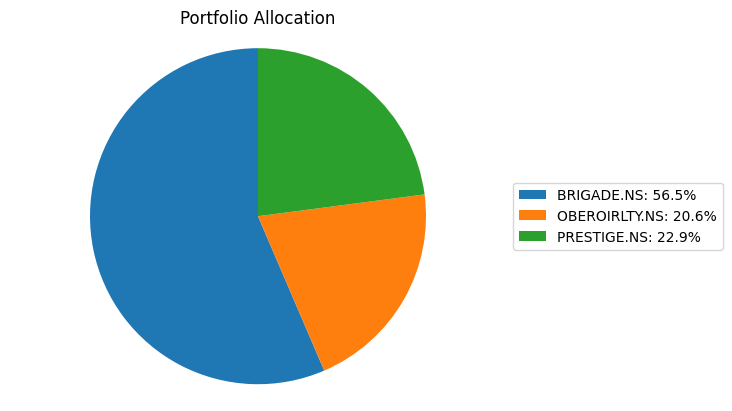

In [15]:
import matplotlib.pyplot as plt

# Extract the assets and corresponding weights from the cleaned_weights dictionary
assets = list(cleaned_weights.keys())
weights = list(cleaned_weights.values())

# Filter out labels with 0.0% weight
non_zero_assets = [asset for asset, weight in cleaned_weights.items() if weight > 0.0]
non_zero_weights = [weight for weight in cleaned_weights.values() if weight > 0.0]

# Check if there are non-zero weights
if not non_zero_weights:
    print("No assets with non-zero weights.")
else:
    # Create a pie chart
    fig, ax = plt.subplots()
    wedges, _ = ax.pie(non_zero_weights, startangle=90)

    # Set aspect ratio to be equal so that pie is drawn as a circle
    ax.axis('equal')

    # Create a legend with custom labels using non-zero assets and weights
    legend_labels = [f'{label}: {weight:.1%}' for label, weight in zip(non_zero_assets, non_zero_weights)]
    ax.legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Set a title for the pie chart
    ax.set_title('Portfolio Allocation')

    # Display the pie chart
    plt.show()


[*********************100%***********************]  3 of 3 completed


Overall Percentage Change: 2.52%


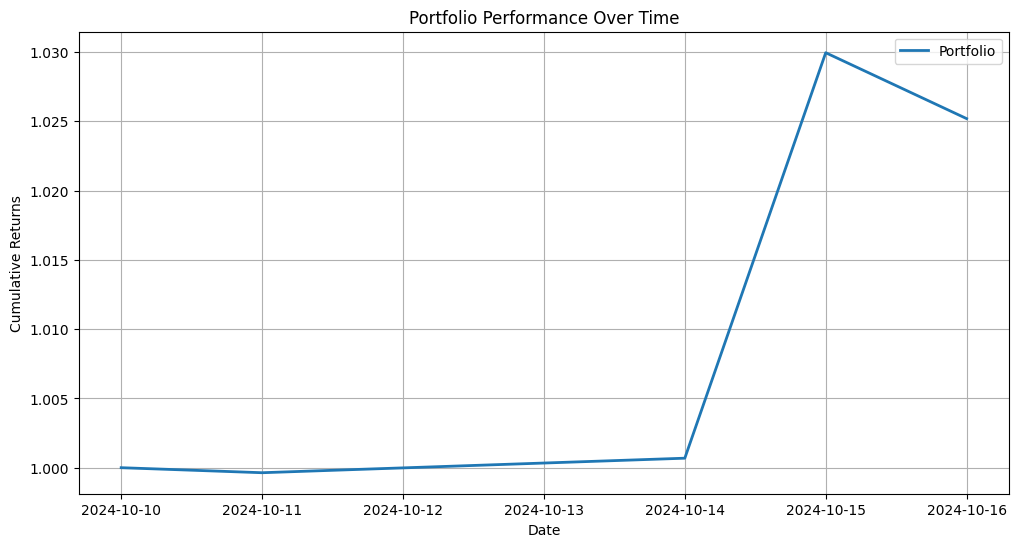

In [16]:
# Fetch historical data for each asset
data = yf.download(non_zero_assets, start=end_date, end=end_date_test)

# Calculate daily returns for each asset
daily_returns = data['Adj Close'].pct_change()

# Convert weights to a NumPy array and calculate portfolio value over time
weights_array = np.array(non_zero_weights)
portfolio_value = np.sum(daily_returns * weights_array, axis=1)

# Calculate cumulative portfolio returns
cumulative_returns = (1 + portfolio_value).cumprod()
overall_percentage_change = (cumulative_returns.iloc[-1] - 1) * 100
print(f'Overall Percentage Change: {overall_percentage_change:.2f}%')


# Plot the cumulative portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='Portfolio', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Performance Over Time')
plt.grid(True)
plt.legend()
plt.show()

##Mean-Semivaraince Portfolio

In [17]:
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientSemivariance

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(returns, frequency=no_of_days)
S = risk_models.semicovariance(returns)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe(risk_free_rate=rfr)
# print("These are the raw weights: ", raw_weights)
cleaned_weights = ef.clean_weights()
# print("These are the cleaned weights: ", cleaned_weights)
ef.portfolio_performance(verbose=True)

Expected annual return: 0.4%
Annual volatility: 24.3%
Sharpe Ratio: 0.01


(0.003987916384549526, 0.2426538620653317, 0.011901382322824882)

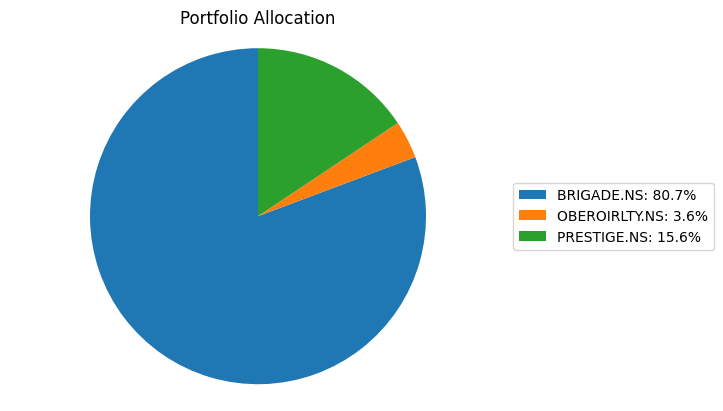

In [18]:
import matplotlib.pyplot as plt

# Extract the assets and corresponding weights from the cleaned_weights dictionary
assets = list(cleaned_weights.keys())
weights = list(cleaned_weights.values())

# Filter out labels with 0.0% weight
non_zero_assets_msv = [asset for asset, weight in cleaned_weights.items() if weight > 0.0]
non_zero_weights_msv = [weight for weight in cleaned_weights.values() if weight > 0.0]

# Check if there are non-zero weights
if not non_zero_weights_msv:
    print("No assets with non-zero weights.")
else:
    # Create a pie chart
    fig, ax = plt.subplots()
    wedges, _ = ax.pie(non_zero_weights_msv, startangle=90)

    # Set aspect ratio to be equal so that pie is drawn as a circle
    ax.axis('equal')

    # Create a legend with custom labels using non-zero assets and weights
    legend_labels = [f'{label}: {weight:.1%}' for label, weight in zip(non_zero_assets_msv, non_zero_weights_msv)]
    ax.legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Set a title for the pie chart
    ax.set_title('Portfolio Allocation')

    # Display the pie chart
    plt.show()


[*********************100%***********************]  3 of 3 completed


Overall Percentage Change: 1.51%


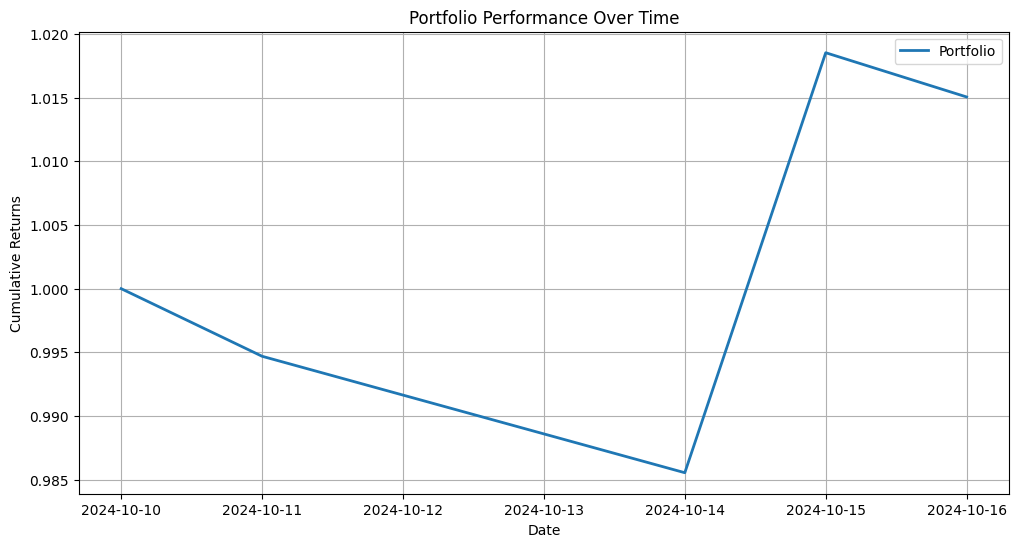

In [19]:
# Fetch historical data for each asset
data = yf.download(non_zero_assets_msv, start=end_date, end=end_date_test)

# Calculate daily returns for each asset
daily_returns = data['Adj Close'].pct_change()

# Convert weights to a NumPy array and calculate portfolio value over time
weights_array = np.array(non_zero_weights_msv)
portfolio_value = np.sum(daily_returns * weights_array, axis=1)

# Calculate cumulative portfolio returns
cumulative_returns = (1 + portfolio_value).cumprod()
overall_percentage_change = (cumulative_returns.iloc[-1] - 1) * 100
print(f'Overall Percentage Change: {overall_percentage_change:.2f}%')


# Plot the cumulative portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='Portfolio', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Performance Over Time')
plt.grid(True)
plt.legend()
plt.show()

##Equal-weighted Portfolio

[*********************100%***********************]  5 of 5 completed


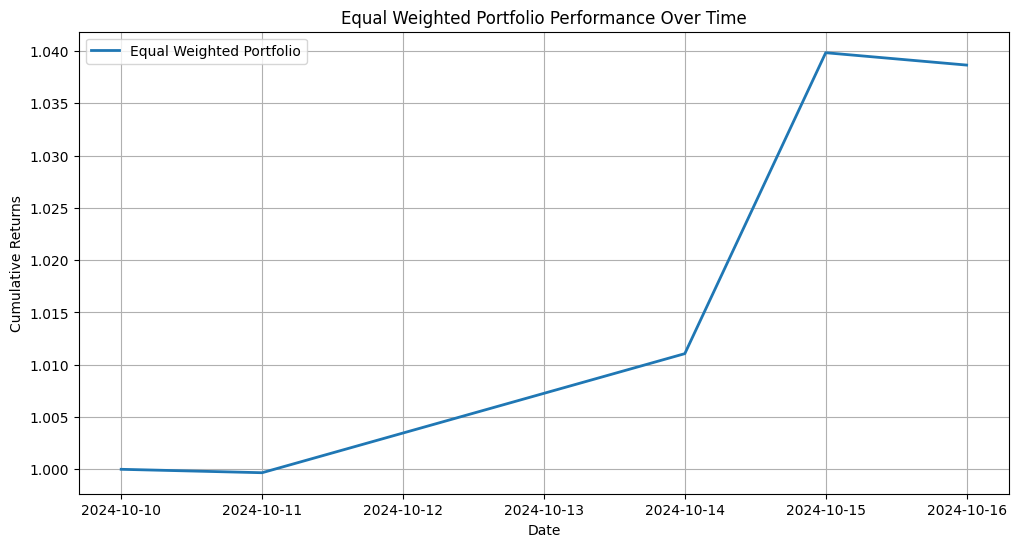

Overall Percentage Return of Equal Weighted Portfolio: 3.86%


In [20]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical data for each asset
data = yf.download(assets, start=end_date, end=end_date_test)

# Calculate daily returns for each asset
daily_returns = data['Adj Close'].pct_change()

# Calculate the percentage return for an equally weighted portfolio
n_assets = len(assets)
weights = np.ones(n_assets) / n_assets
portfolio_value = np.sum(daily_returns * weights, axis=1)

# Calculate cumulative portfolio returns
cumulative_returns = (1 + portfolio_value).cumprod()

# Plot the cumulative portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='Equal Weighted Portfolio', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Equal Weighted Portfolio Performance Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Calculate and print the overall percentage return of the equal weighted portfolio
overall_percentage_return = (cumulative_returns.iloc[-1] - 1) * 100
print(f'Overall Percentage Return of Equal Weighted Portfolio: {overall_percentage_return:.2f}%')


##Max Sharpe Portfolio

In [21]:
import pandas as pd
import numpy as np
import yfinance as yf

try:

    # Define the list of stock tickers

    # Retrieve historical price data
    data = adj_close

    # Calculate stock returns for the selected tickers
    returns = data[tickers].pct_change().dropna()

    # Number of stocks
    num_stocks = len(tickers)

    # Generate random portfolio weights
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)

    # Define the risk-free rate
    risk_free_rate = rfr

    # Initialize variables for maximum Sharpe ratio calculation
    max_sharpe_ratio = float('-inf')
    optimal_weights = None

    # Calculate returns and volatility for each set of weights
    for _ in range(100000):
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)

        portfolio_return = np.dot(returns.mean().values, weights) * no_of_days
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * no_of_days, weights)))

        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

        if sharpe_ratio > max_sharpe_ratio:
            max_sharpe_ratio = sharpe_ratio
            optimal_weights = weights

    portfolio_value = 100000

    # Calculate the investment amount for each stock
    investment_amounts = optimal_weights * portfolio_value

    # Retrieve current price data
    current_data = yf.download(tickers, period='1d')['Close']

    # Calculate the current value of each stock
    current_values = current_data.iloc[-1]

    # Calculate the number of stocks for each investment amount
    num_stocks = (investment_amounts // current_values)

    # Print the tickers with their investment amounts
    for i, ticker in enumerate(tickers):
        ratio = investment_amounts[i]/portfolio_value
    #     print(f'{ticker}: {ratio}')
except:
    pass

[*********************100%***********************]  5 of 5 completed


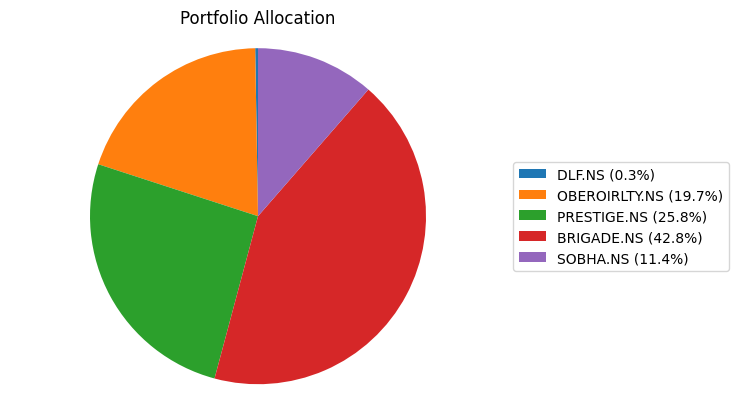

0.09752361537203426


In [22]:
import matplotlib.pyplot as plt

# Define the labels for the pie chart
labels = tickers

# Remove tickers with 0 investment amount
non_zero_investments = investment_amounts[~np.isclose(investment_amounts, 0)]
non_zero_ratios = [(ratio*100) for ratio in (investment_amounts/portfolio_value) if not np.isclose(ratio, 0)]
non_zero_labels = [f"{label} ({ratio:.1f}%)" for label, investment_amount, ratio in zip(labels, investment_amounts, non_zero_ratios) if not np.isclose(ratio, 0)]

# Create a pie chart
fig, ax = plt.subplots()
wedges, _ = ax.pie(non_zero_investments, startangle=90)

# Set aspect ratio to be equal so that pie is drawn as a circle
ax.axis('equal')

# Add labels to the pie chart
ax.legend(wedges, non_zero_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Portfolio Allocation")
plt.show()

print(max_sharpe_ratio)


In [23]:
assets = []
weights = []

# Loop through the portfolio list and extract assets and weights
for item in non_zero_labels:
    parts = item.split(' ')
    asset = parts[0]
    weight = float(parts[1][1:-2])  # Removing '%' and converting to float
    assets.append(asset)
    weights.append(weight)

print("Assets:", assets)
print("Weights:", weights)

Assets: ['DLF.NS', 'OBEROIRLTY.NS', 'PRESTIGE.NS', 'BRIGADE.NS', 'SOBHA.NS']
Weights: [0.3, 19.7, 25.8, 42.8, 11.4]


[*********************100%***********************]  5 of 5 completed


Overall Percentage Change: 3.46%


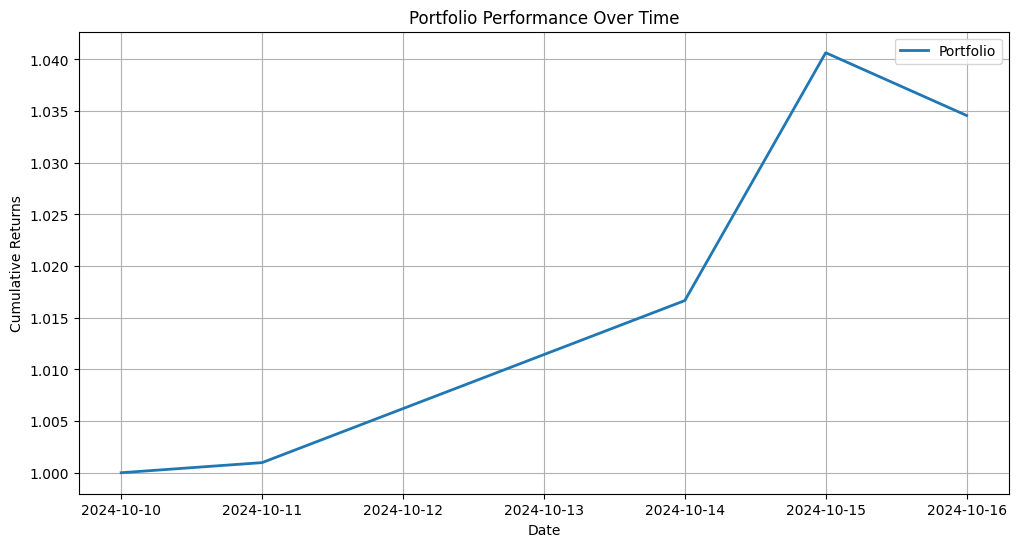

In [24]:
# Fetch historical data for each asset
data = yf.download(assets, start=end_date, end=end_date_test)

# Calculate daily returns for each asset
daily_returns = data['Adj Close'].pct_change()

# Convert weights to a NumPy array and calculate portfolio value over time
weights_array = np.array(weights)
portfolio_value = np.sum(daily_returns * (weights_array / 100), axis=1)

# Calculate cumulative portfolio returns
cumulative_returns = (1 + portfolio_value).cumprod()
overall_percentage_change = (cumulative_returns.iloc[-1] - 1) * 100
print(f'Overall Percentage Change: {overall_percentage_change:.2f}%')

# Plot the cumulative portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='Portfolio', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Performance Over Time')
plt.grid(True)
plt.legend()
plt.show()